In [94]:
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import re

plt.style.use('ggplot')

In [95]:
research_articles = pd.read_csv('train.csv')
research_articles.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [96]:
print(research_articles['ABSTRACT'][5])

  Let $\Omega \subset \mathbb{R}^n$ be a bounded domain satisfying a
Hayman-type asymmetry condition, and let $ D $ be an arbitrary bounded domain
referred to as "obstacle". We are interested in the behaviour of the first
Dirichlet eigenvalue $ \lambda_1(\Omega \setminus (x+D)) $. First, we prove an
upper bound on $ \lambda_1(\Omega \setminus (x+D)) $ in terms of the distance
of the set $ x+D $ to the set of maximum points $ x_0 $ of the first Dirichlet
ground state $ \phi_{\lambda_1} > 0 $ of $ \Omega $. In short, a direct
corollary is that if \begin{equation} \mu_\Omega := \max_{x}\lambda_1(\Omega
\setminus (x+D)) \end{equation} is large enough in terms of $ \lambda_1(\Omega)
$, then all maximizer sets $ x+D $ of $ \mu_\Omega $ are close to each maximum
point $ x_0 $ of $ \phi_{\lambda_1} $.
Second, we discuss the distribution of $ \phi_{\lambda_1(\Omega)} $ and the
possibility to inscribe wavelength balls at a given point in $ \Omega $.
Finally, we specify our observations to convex

In [97]:
lm = WordNetLemmatizer()

def preprocess_text(text):
    # removing inline equations
    corpus = re.sub(r'\$.*?\$|\$\s.*?\s\$|\\begin{equation}\s.*?\s\\end{equation}', '', text)
    # removing equation environments
    corpus = re.sub(r'\\begin{equation}\s.*?\s\\end{equation}', '', corpus)
    # applying tokenization
    corpus = re.split('\W+', corpus)
    # applying lemmatization
    corpus = [lm.lemmatize(word) for word in corpus]
    corpus = " ".join(corpus)
    # set of stop words 
    stop_words = set(stopwords.words("english"))
    # removing the stop words 
    cleaned_corpus = [word for word in  
                              corpus.split()
                              if word.lower() not in stop_words]
    
    return ' '.join(cleaned_corpus)

In [98]:
new_dataframe = research_articles[['TITLE', 'ABSTRACT']]
new_dataframe['ABSTRACT'] = research_articles['ABSTRACT'].apply(lambda x: preprocess_text(x))

C:\Users\Victor Jr\AppData\Local\Temp\ipykernel_3048\3291885379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe['ABSTRACT'] = research_articles['ABSTRACT'].apply(lambda x: preprocess_text(x))


In [99]:
print(new_dataframe['ABSTRACT'][5])

Let bounded domain satisfying Hayman type asymmetry condition let arbitrary bounded domain referred obstacle interested behaviour first Dirichlet eigenvalue First prove upper bound term distance set set maximum point first Dirichlet ground state short direct corollary begin equation mu_ Omega max_ x lambda_1 Omega setminus x end equation large enough term maximizer set close maximum point Second discus distribution possibility inscribe wavelength ball given point Finally specify observation convex obstacle show sufficiently large respect maximizers contain maximum point


In [100]:
new_dataframe.shape

(20972, 2)

In [101]:
no_of_features = 5000
no_of_components = 6
top_n_words = 20

In [102]:
tfidf = TfidfVectorizer(max_df=0.95, 
                        min_df=3, 
                        max_features=no_of_features)

In [103]:
dtm = tfidf.fit_transform(new_dataframe['ABSTRACT'])
dtm

<20972x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1259857 stored elements in Compressed Sparse Row format>

In [104]:
tfidf_features = tfidf.get_feature_names_out()
len(tfidf_features)

5000

In [120]:
nmf_model = NMF(n_components=6,
                random_state=42,
                init='nndsvd')
nmf_model

NMF(init='nndsvd', n_components=6, random_state=42)

In [121]:
nmf_model.fit(dtm)

NMF(init='nndsvd', n_components=6, random_state=42)

In [144]:
def display_topics(model, feature_names, no_top_words):
    """
    Generates the number of top words specified in no_to_words
    for the specified model.
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" %topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]), '\n')
        
def plot_top_words(model, feature_names, n_top_words, title):
    """
        Generates the visual representation of the number of top words
        specified in n_top_words for the model.
    """
    fig, axes = plt.subplots(2, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

In [123]:
display_topics(nmf_model, tfidf_features, top_n_words)

Topic 0:
algorithm problem method optimization optimal time solution stochastic gradient convergence convex proposed function control matrix bound learning based linear approach 

Topic 1:
group space equation algebra function prove operator finite theory result theorem solution manifold class give type condition set case polynomial 

Topic 2:
spin phase field magnetic system energy state temperature quantum transition electron effect interaction wave density mass particle two star material 

Topic 3:
network learning neural deep task image training feature architecture classification method performance representation approach based machine convolutional system art end 

Topic 4:
graph vertex edge node network random number algorithm degree structure tree set problem path time community property directed walk connected 

Topic 5:
model data distribution method estimator parameter process sample approach inference analysis based estimation variable bayesian test regression proposed esti

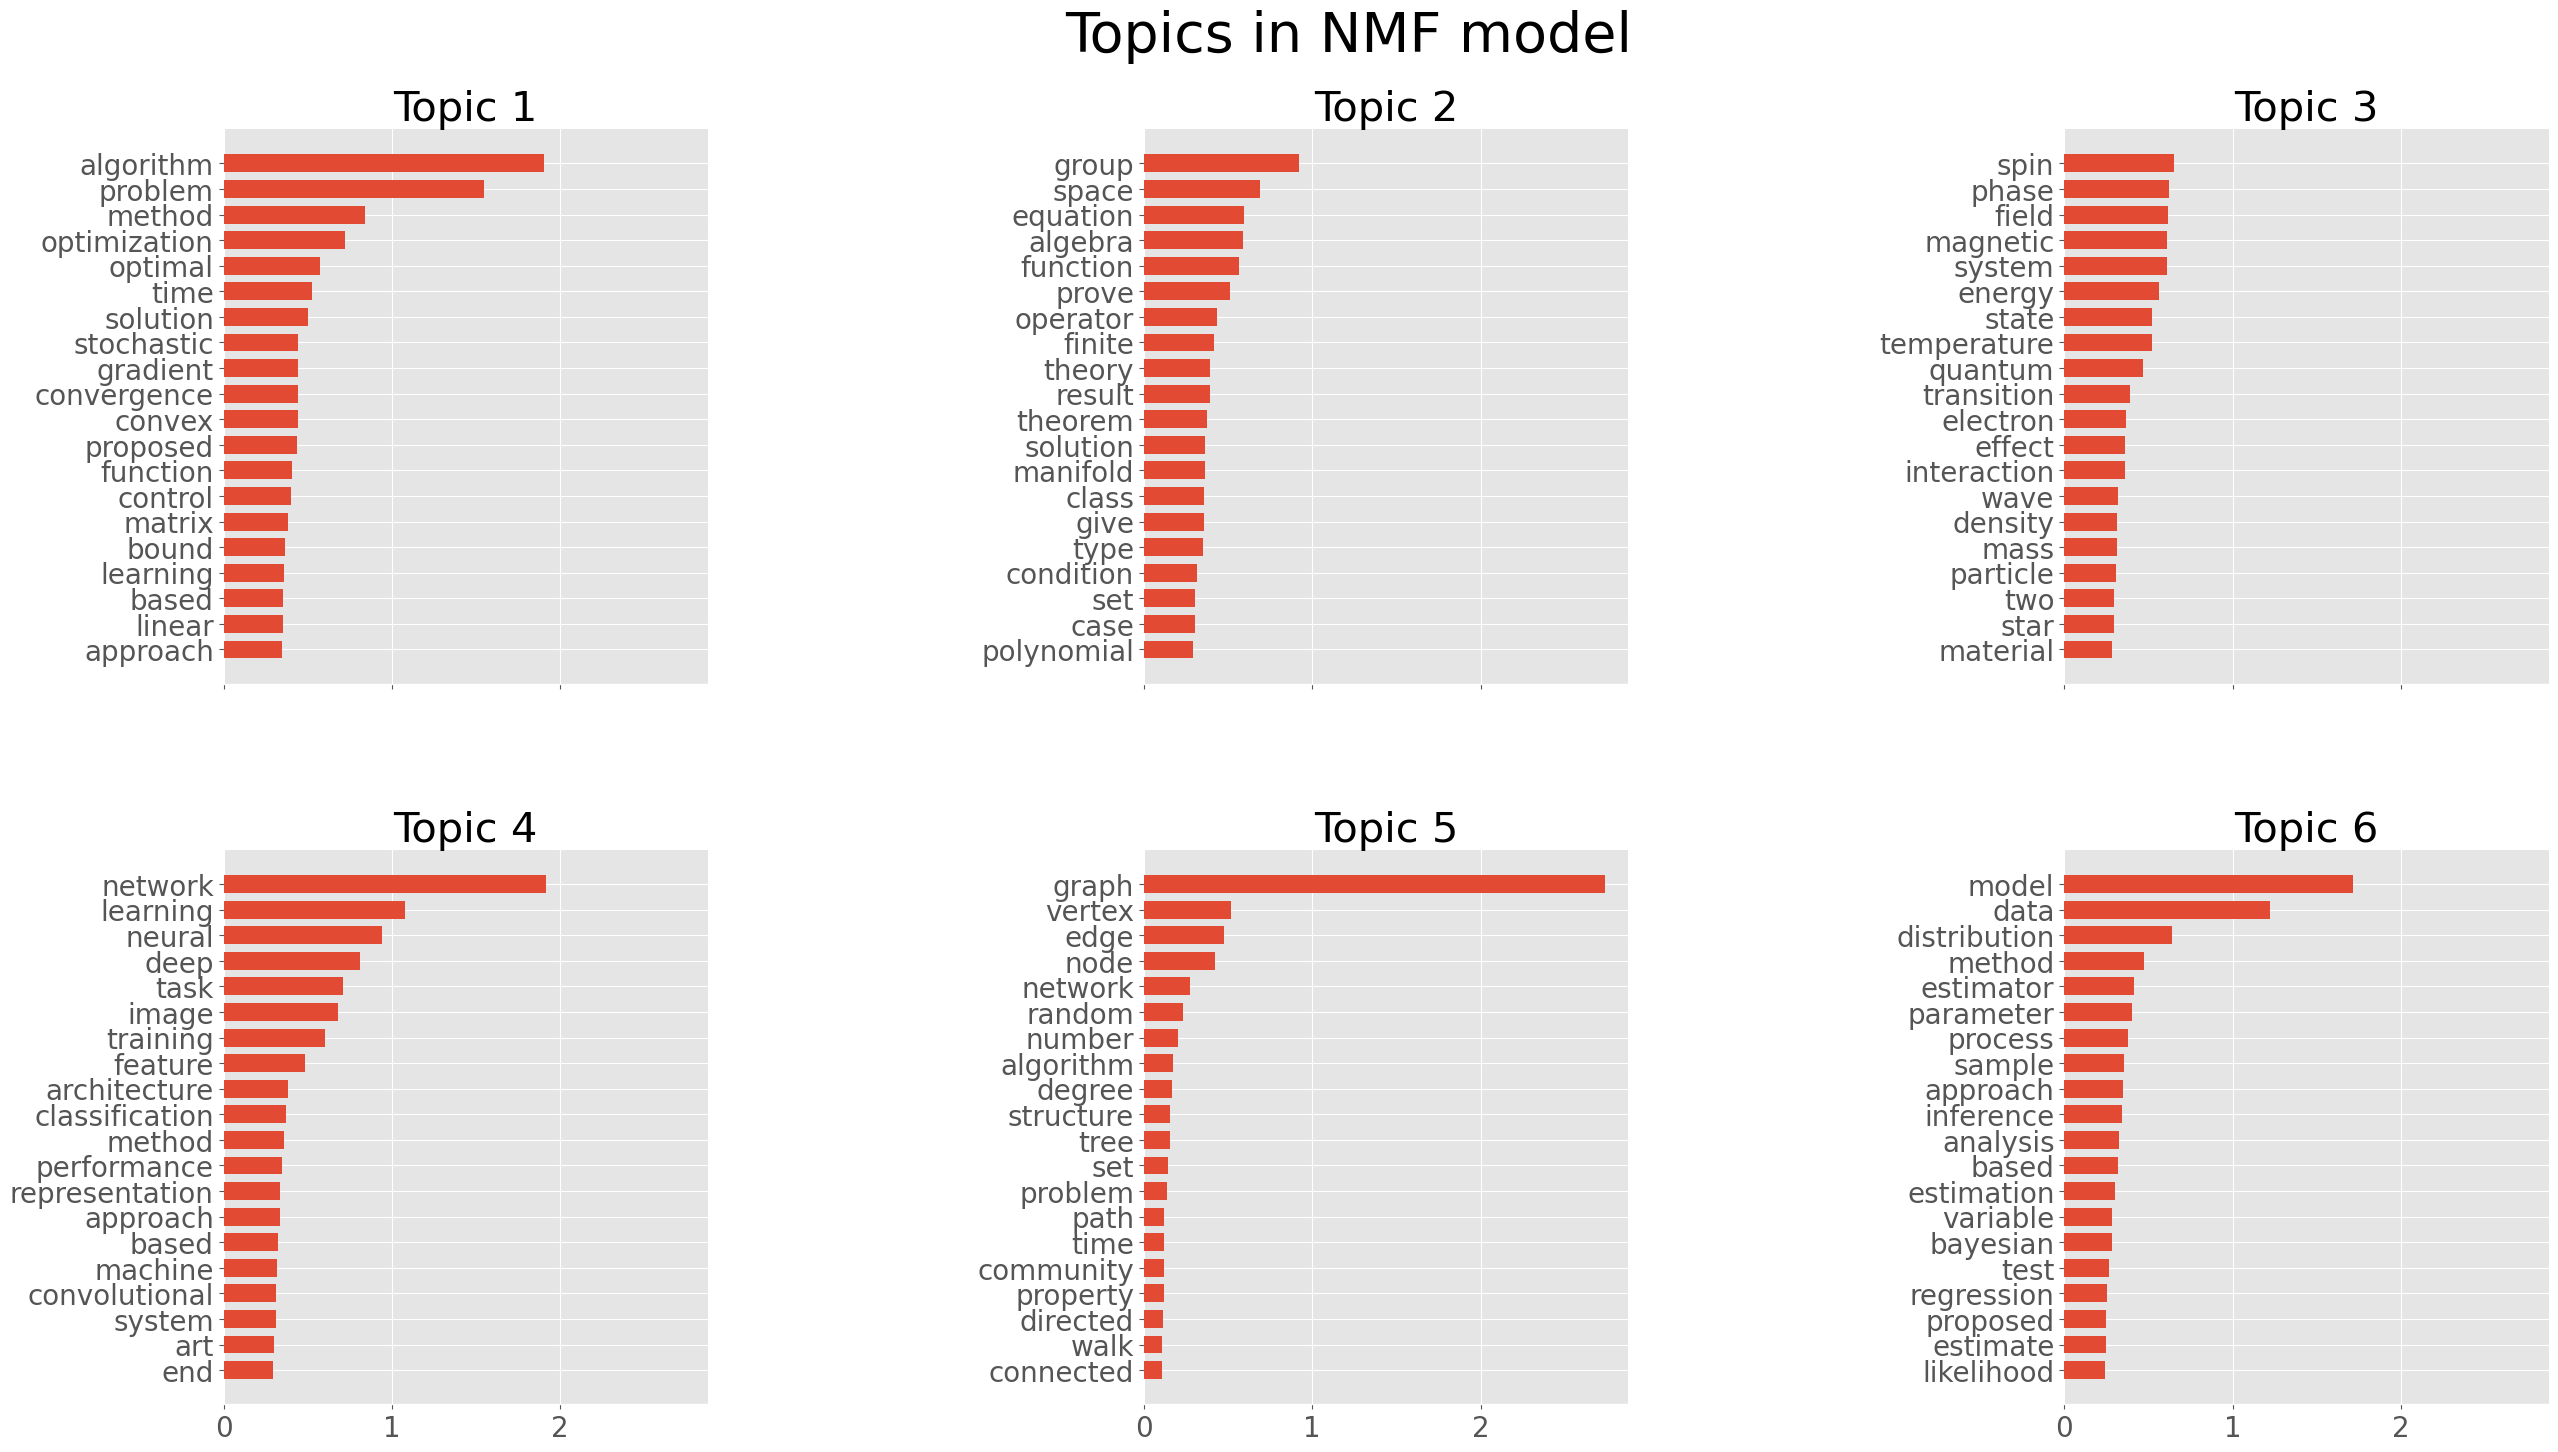

In [124]:
plot_top_words(nmf_model, tfidf_features, top_n_words, 'Topics in NMF model')

In [125]:
topic_dict_nmf = {0: 'Quantitative Finance', 
              1: 'Mathematics', 
              2: 'Physics', 
              3: 'Computer Science', 
              4: 'Quantitative Biology', 
              5: 'Statistics'}

In [126]:
topic_results_nmf = nmf_model.transform(dtm)
topic_results_nmf

array([[3.55433408e-03, 0.00000000e+00, 4.56070957e-03, 1.53516183e-02,
        0.00000000e+00, 8.62871680e-02],
       [0.00000000e+00, 5.47792360e-03, 0.00000000e+00, 6.12141005e-02,
        0.00000000e+00, 0.00000000e+00],
       [2.27216287e-03, 4.14192878e-02, 0.00000000e+00, 2.46107409e-06,
        0.00000000e+00, 3.93069347e-03],
       ...,
       [0.00000000e+00, 1.07012655e-02, 8.15607396e-03, 5.24814856e-02,
        5.08840944e-05, 1.26120544e-02],
       [2.58683905e-02, 5.79742272e-03, 4.78292355e-04, 0.00000000e+00,
        1.94260361e-04, 4.99722954e-02],
       [1.33023277e-02, 4.82595704e-03, 0.00000000e+00, 0.00000000e+00,
        1.26512718e-03, 2.05639268e-02]])

In [127]:
topic_results_nmf.argmax(axis=1)

new_dataframe.loc[:,'TOPICS_NMF'] = topic_results_nmf.argmax(axis=1)
new_dataframe.loc[:,'TOPICS_NMF'] = new_dataframe['TOPICS_NMF'].map(topic_dict_nmf)

new_dataframe.head(10)

,TITLE,ABSTRACT,TOPICS_NMF,TOPICS_LDA
0,Reconstructing Subject-Specific Effect Maps,Predictive model allow subject specific infere...,Statistics,Statistics
1,Rotation Invariance Neural Network,Rotation invariance translation invariance gre...,Computer Science,Statistics
2,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyharmoni...,Mathematics,Mathematics
3,A finite element approximation for the stochas...,stochastic Landau Lifshitz Gilbert LLG equatio...,Mathematics,Mathematics
4,Comparative study of Discrete Wavelet Transfor...,Fourier transform infra red FTIR spectrum samp...,Statistics,Statistics
5,On maximizing the fundamental frequency of the...,Let bounded domain satisfying Hayman type asym...,Mathematics,Mathematics
6,On the rotation period and shape of the hyperb...,observed newly discovered hyperbolic minor pla...,Physics,Quantitative Finance
7,Adverse effects of polymer coating on heat tra...,ability metallic nanoparticles supply heat liq...,Physics,Mathematics
8,SPH calculations of Mars-scale collisions: the...,model large scale 2000km impact Mars like plan...,Physics,Mathematics
9,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility host individual le...,Statistics,Statistics


In [131]:
LDA = LatentDirichletAllocation(n_components=6,
                                random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=6, random_state=42)

In [132]:
display_topics(LDA, tfidf_features, top_n_words)

Topic 0:
group algebra category finite theory prove module subgroup ring space set logic let give show type conjecture representation proof theorem 

Topic 1:
network model learning method data algorithm approach neural image based task deep training performance proposed system problem feature using time 

Topic 2:
field phase energy spin magnetic temperature state model system quantum effect mass particle electron star wave transition two density galaxy 

Topic 3:
network data user model system social game paper information analysis research based software study community different ha approach time process 

Topic 4:
algorithm problem graph distribution matrix bound function method estimator model number random result time linear show convergence stochastic set convex 

Topic 5:
equation solution space function operator manifold boundary prove result condition problem system paper differential theorem surface case point integral type 



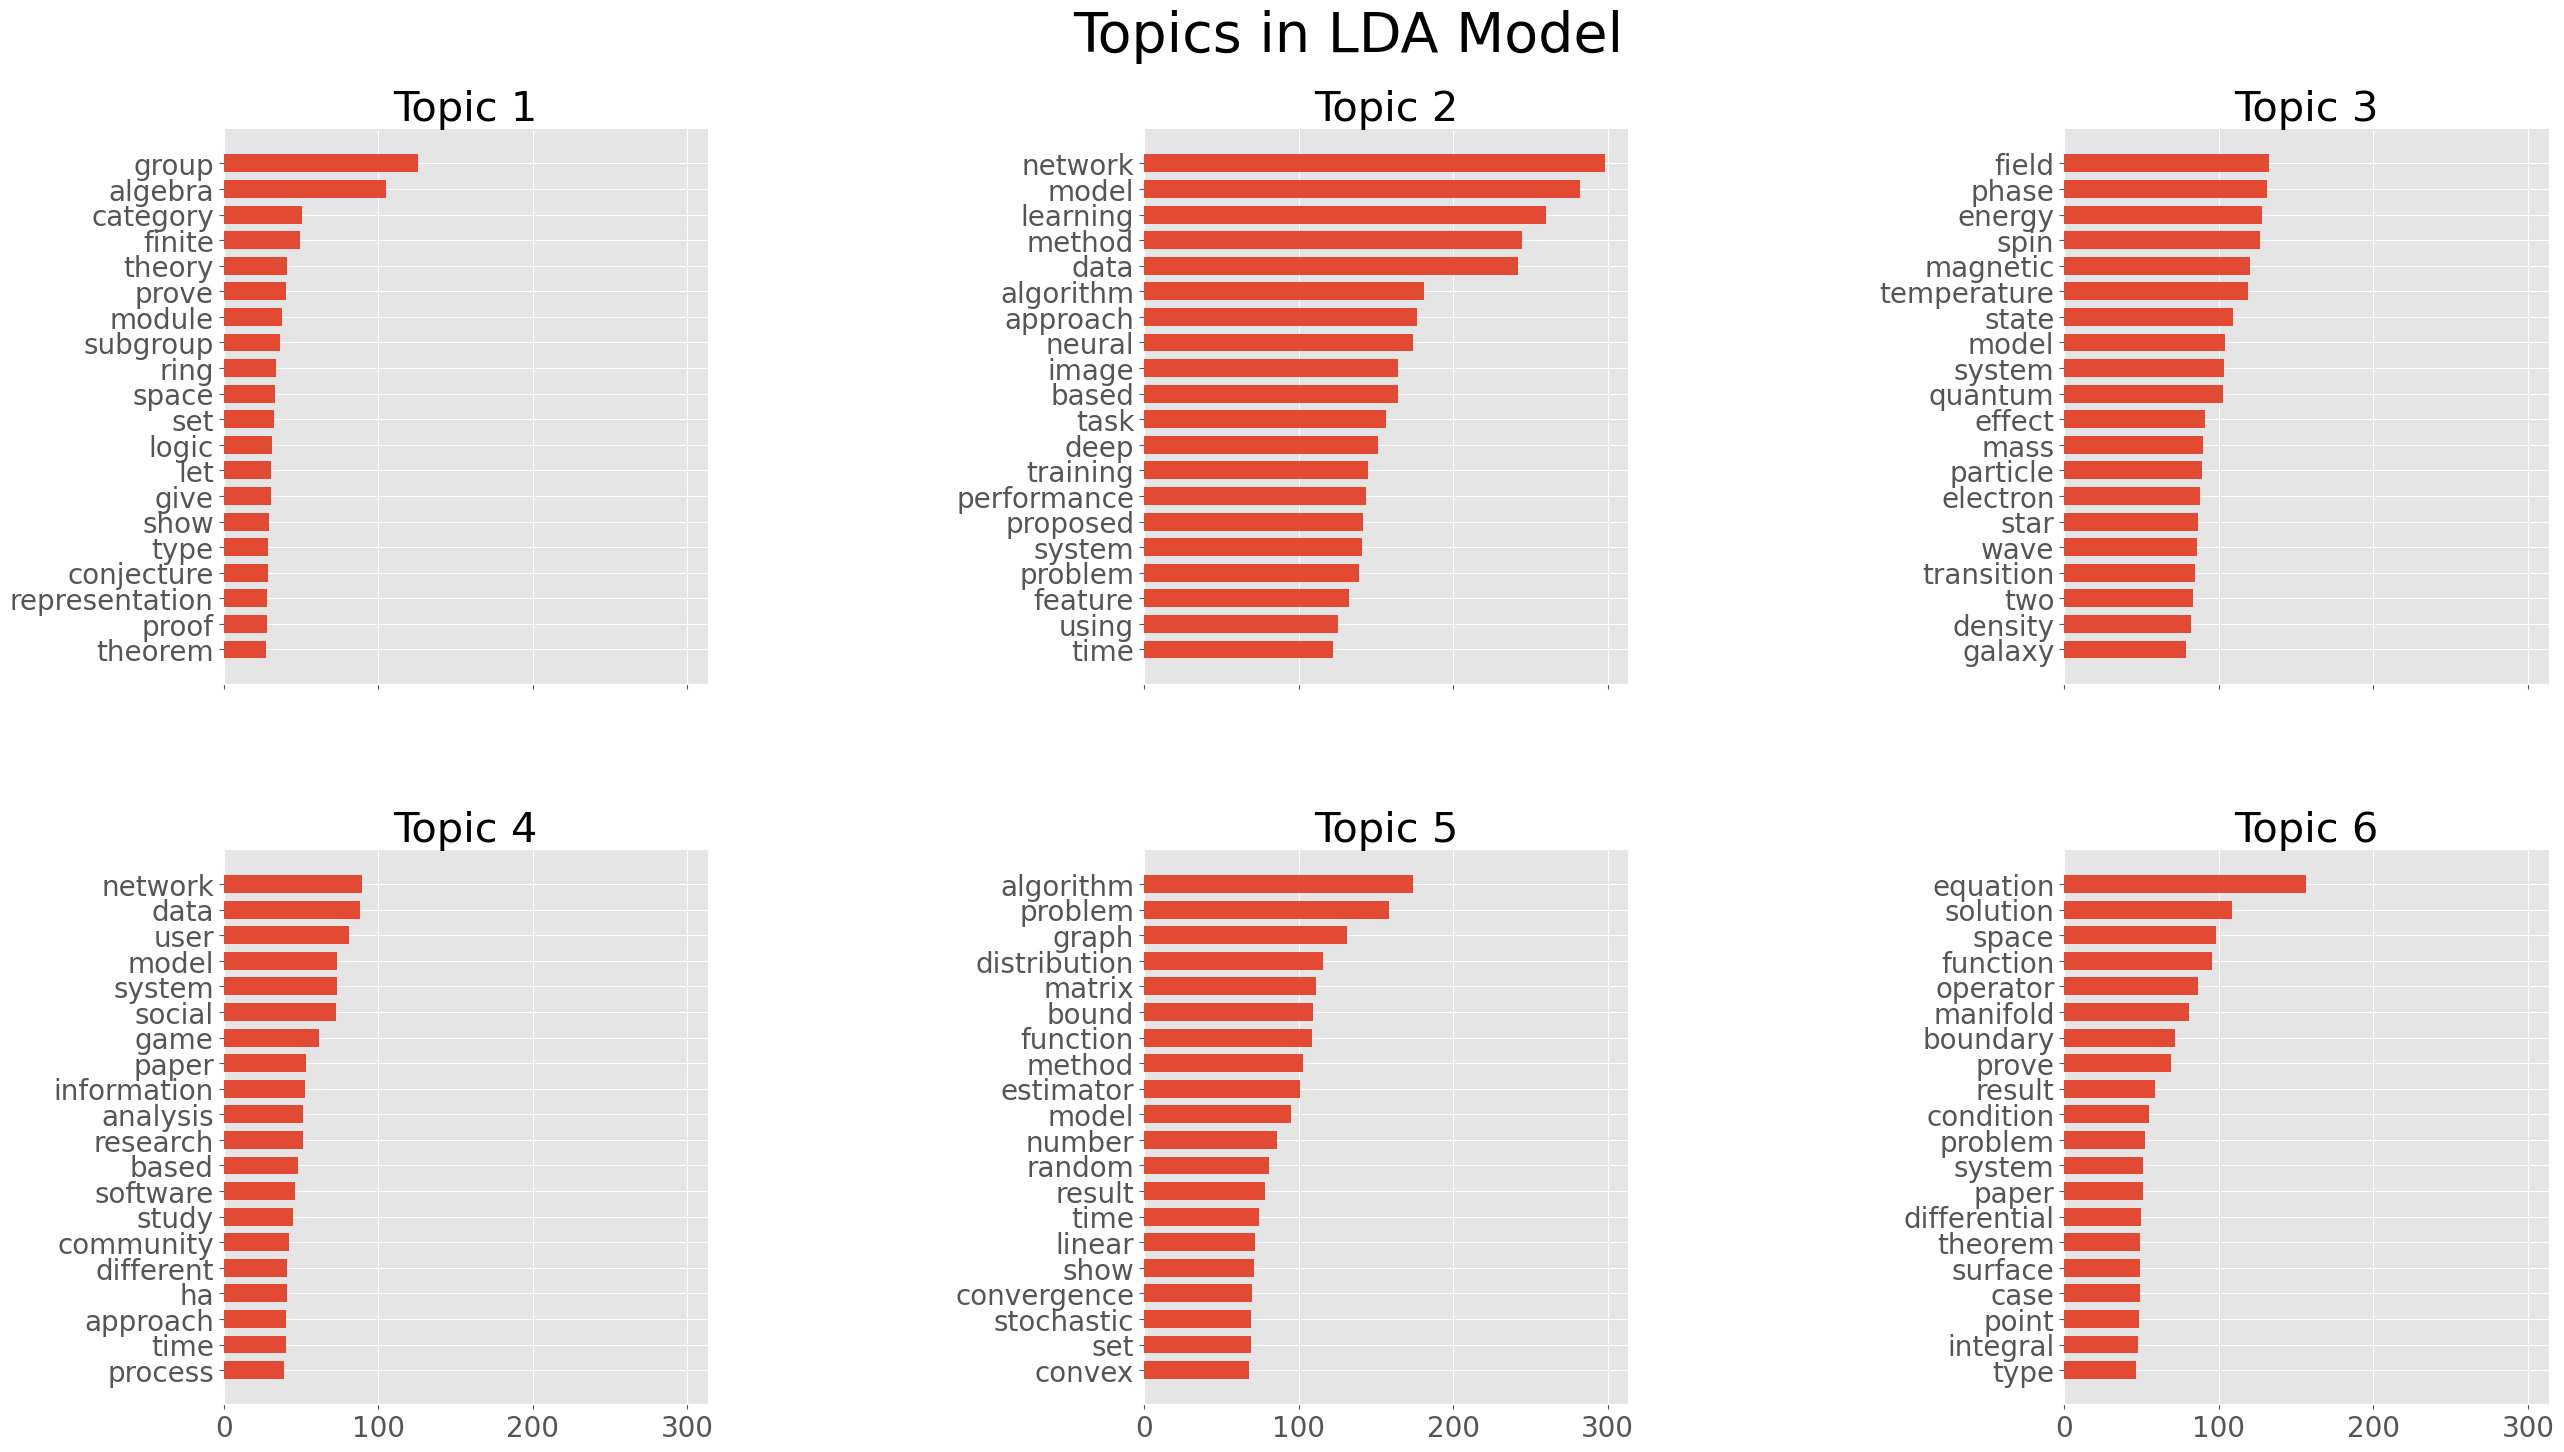

In [133]:
plot_top_words(LDA, tfidf_features, top_n_words, 'Topics in LDA Model')

In [134]:
topic_dict_lda = {0: 'Mathematics', 
              1: 'Computer Science', 
              2: 'Physics', 
              3: 'Quantitative Biology', 
              4: 'Statistics', 
              5: 'Quantitative Finance'}

In [135]:
topic_results_lda = LDA.transform(dtm)
topic_results_lda

array([[0.01738442, 0.91140025, 0.01875132, 0.01751321, 0.01746955,
        0.01748126],
       [0.0310821 , 0.85758402, 0.02776959, 0.02761447, 0.02788784,
        0.02806198],
       [0.03411687, 0.03394749, 0.03389035, 0.03388859, 0.0341416 ,
        0.8300151 ],
       ...,
       [0.02203273, 0.88938104, 0.02207319, 0.02225527, 0.02208678,
        0.02217098],
       [0.01954635, 0.01985007, 0.02994104, 0.01980767, 0.89123723,
        0.01961763],
       [0.02649889, 0.02655624, 0.02644227, 0.34121442, 0.55283067,
        0.0264575 ]])

In [136]:
topic_results_lda.argmax(axis=1)

new_dataframe.loc[:,'TOPICS_LDA'] = topic_results_lda.argmax(axis=1)
new_dataframe.loc[:,'TOPICS_LDA'] = new_dataframe['TOPICS_LDA'].map(topic_dict_lda)

new_dataframe.head(20)

,TITLE,ABSTRACT,TOPICS_NMF,TOPICS_LDA
0,Reconstructing Subject-Specific Effect Maps,Predictive model allow subject specific infere...,Statistics,Computer Science
1,Rotation Invariance Neural Network,Rotation invariance translation invariance gre...,Computer Science,Computer Science
2,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyharmoni...,Mathematics,Quantitative Finance
3,A finite element approximation for the stochas...,stochastic Landau Lifshitz Gilbert LLG equatio...,Mathematics,Quantitative Finance
4,Comparative study of Discrete Wavelet Transfor...,Fourier transform infra red FTIR spectrum samp...,Statistics,Computer Science
5,On maximizing the fundamental frequency of the...,Let bounded domain satisfying Hayman type asym...,Mathematics,Quantitative Finance
6,On the rotation period and shape of the hyperb...,observed newly discovered hyperbolic minor pla...,Physics,Physics
7,Adverse effects of polymer coating on heat tra...,ability metallic nanoparticles supply heat liq...,Physics,Physics
8,SPH calculations of Mars-scale collisions: the...,model large scale 2000km impact Mars like plan...,Physics,Physics
9,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility host individual le...,Statistics,Quantitative Biology


In [119]:
test_data = pd.read_csv('test.csv')
test_data.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [148]:
dtm_test = tfidf.transform(test_data['ABSTRACT'].apply(lambda x: preprocess_text(x)))
nmf_model.fit(dtm_test)

NMF(init='nndsvd', n_components=6, random_state=42)

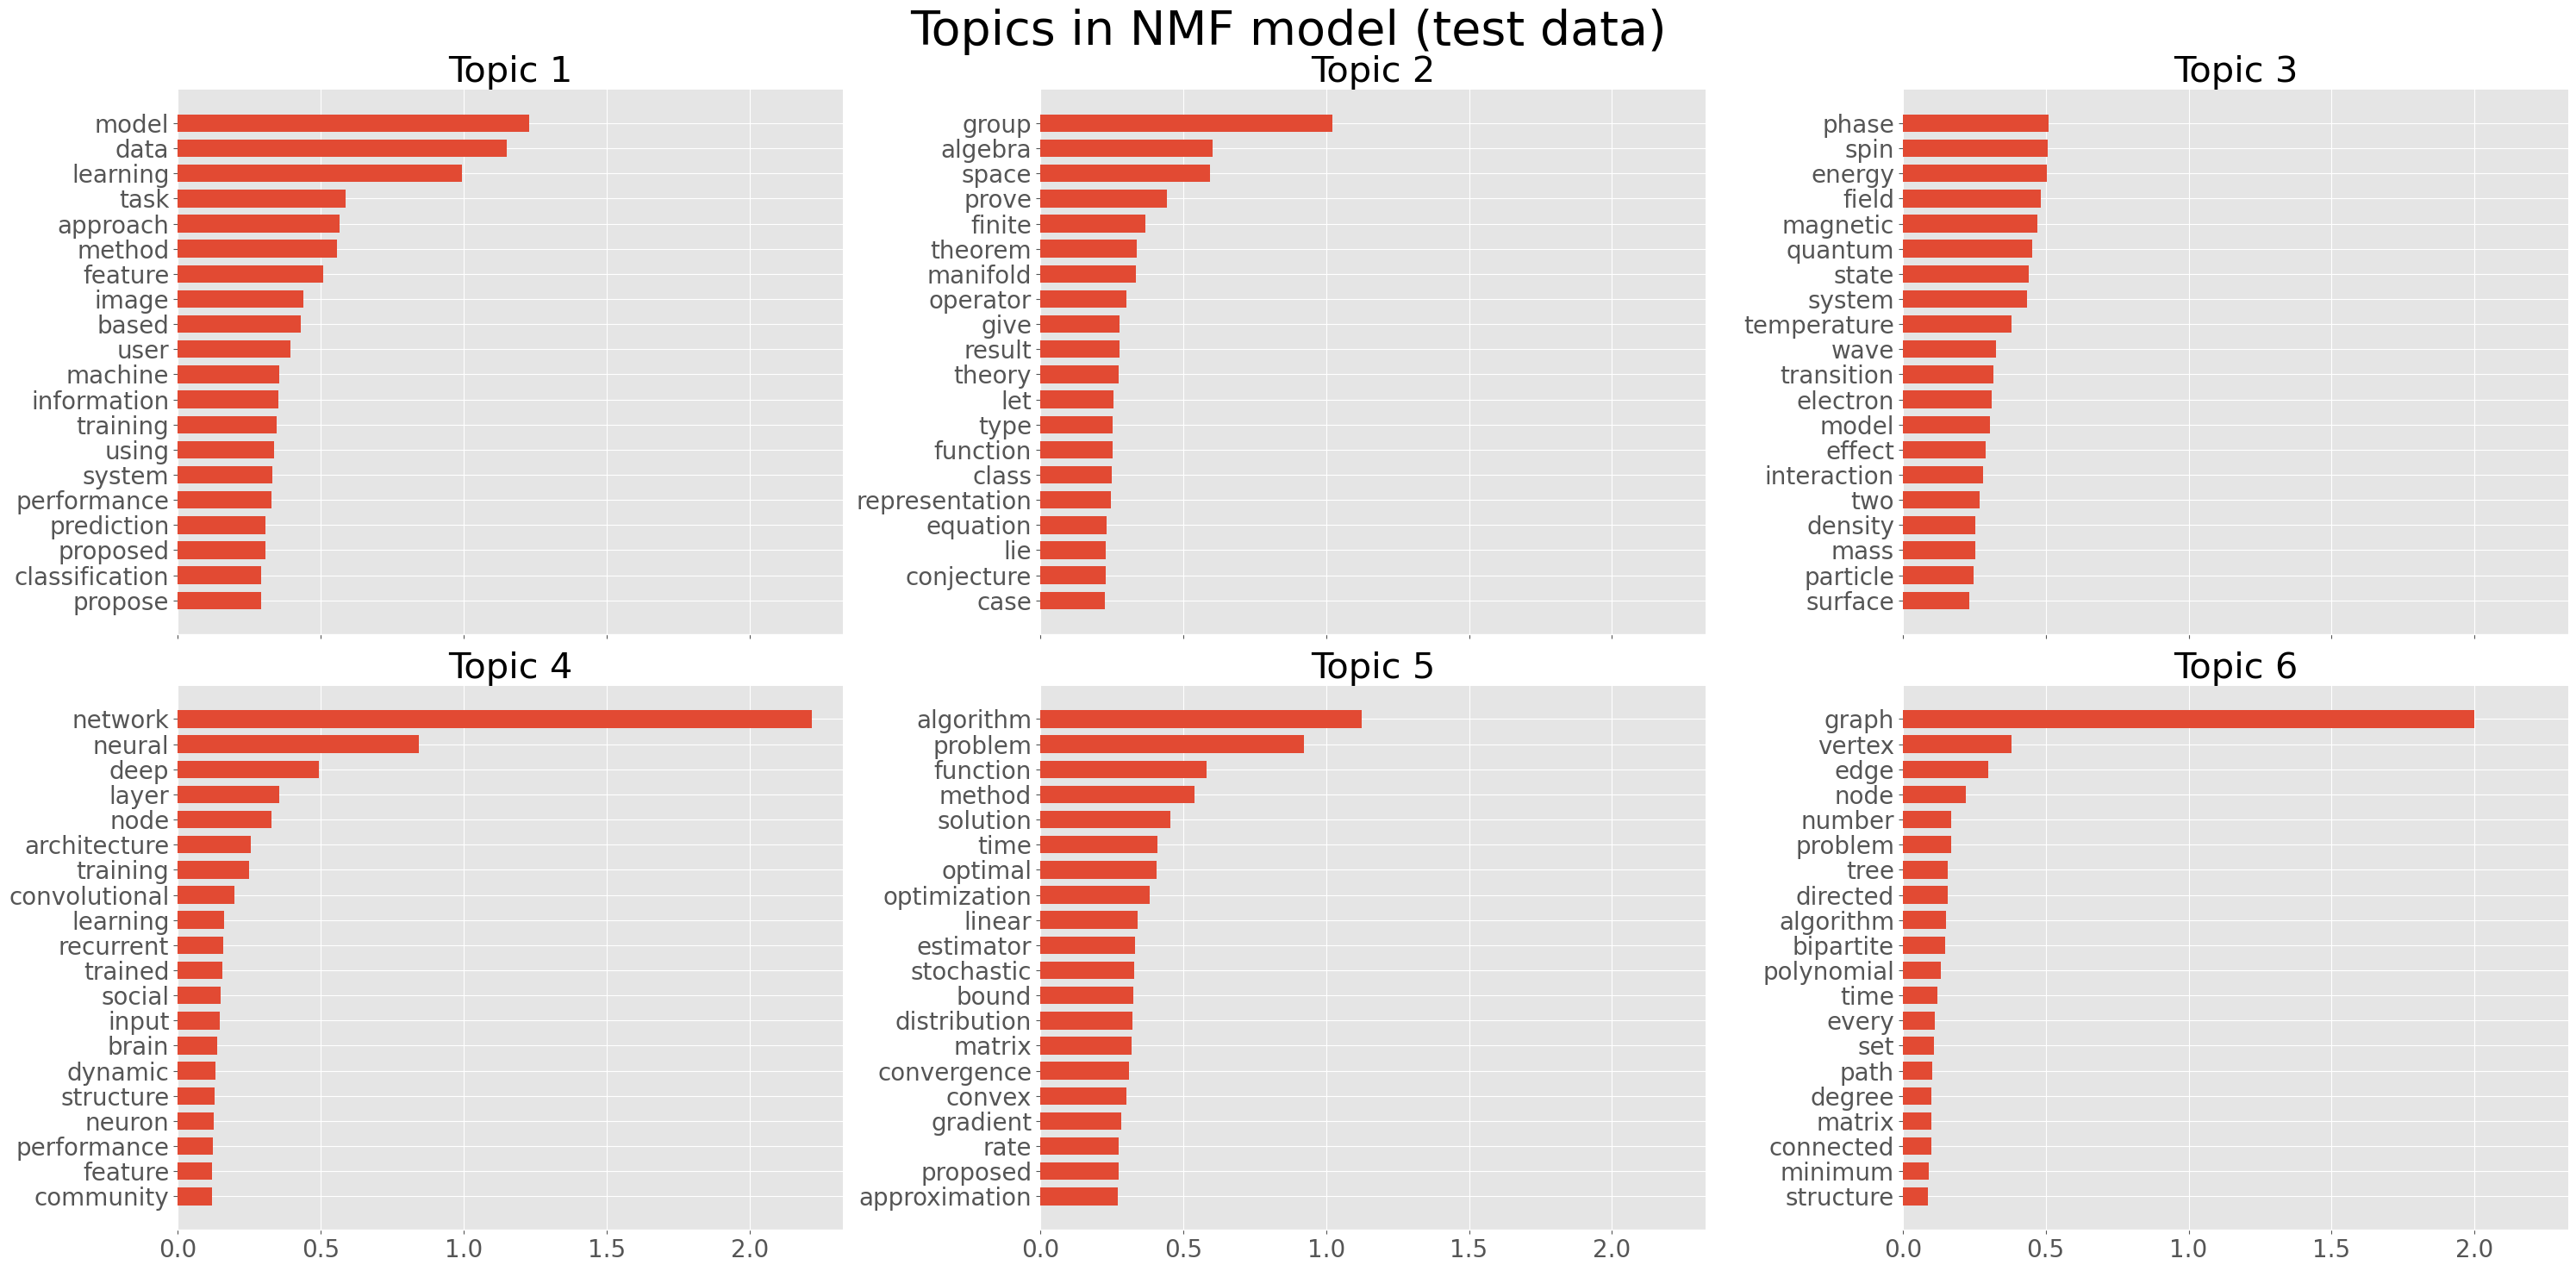

In [149]:
plot_top_words(nmf_model, tfidf_features, top_n_words, 'Topics in NMF model (test data)')

In [150]:
LDA.fit(dtm_test)

LatentDirichletAllocation(n_components=6, random_state=42)

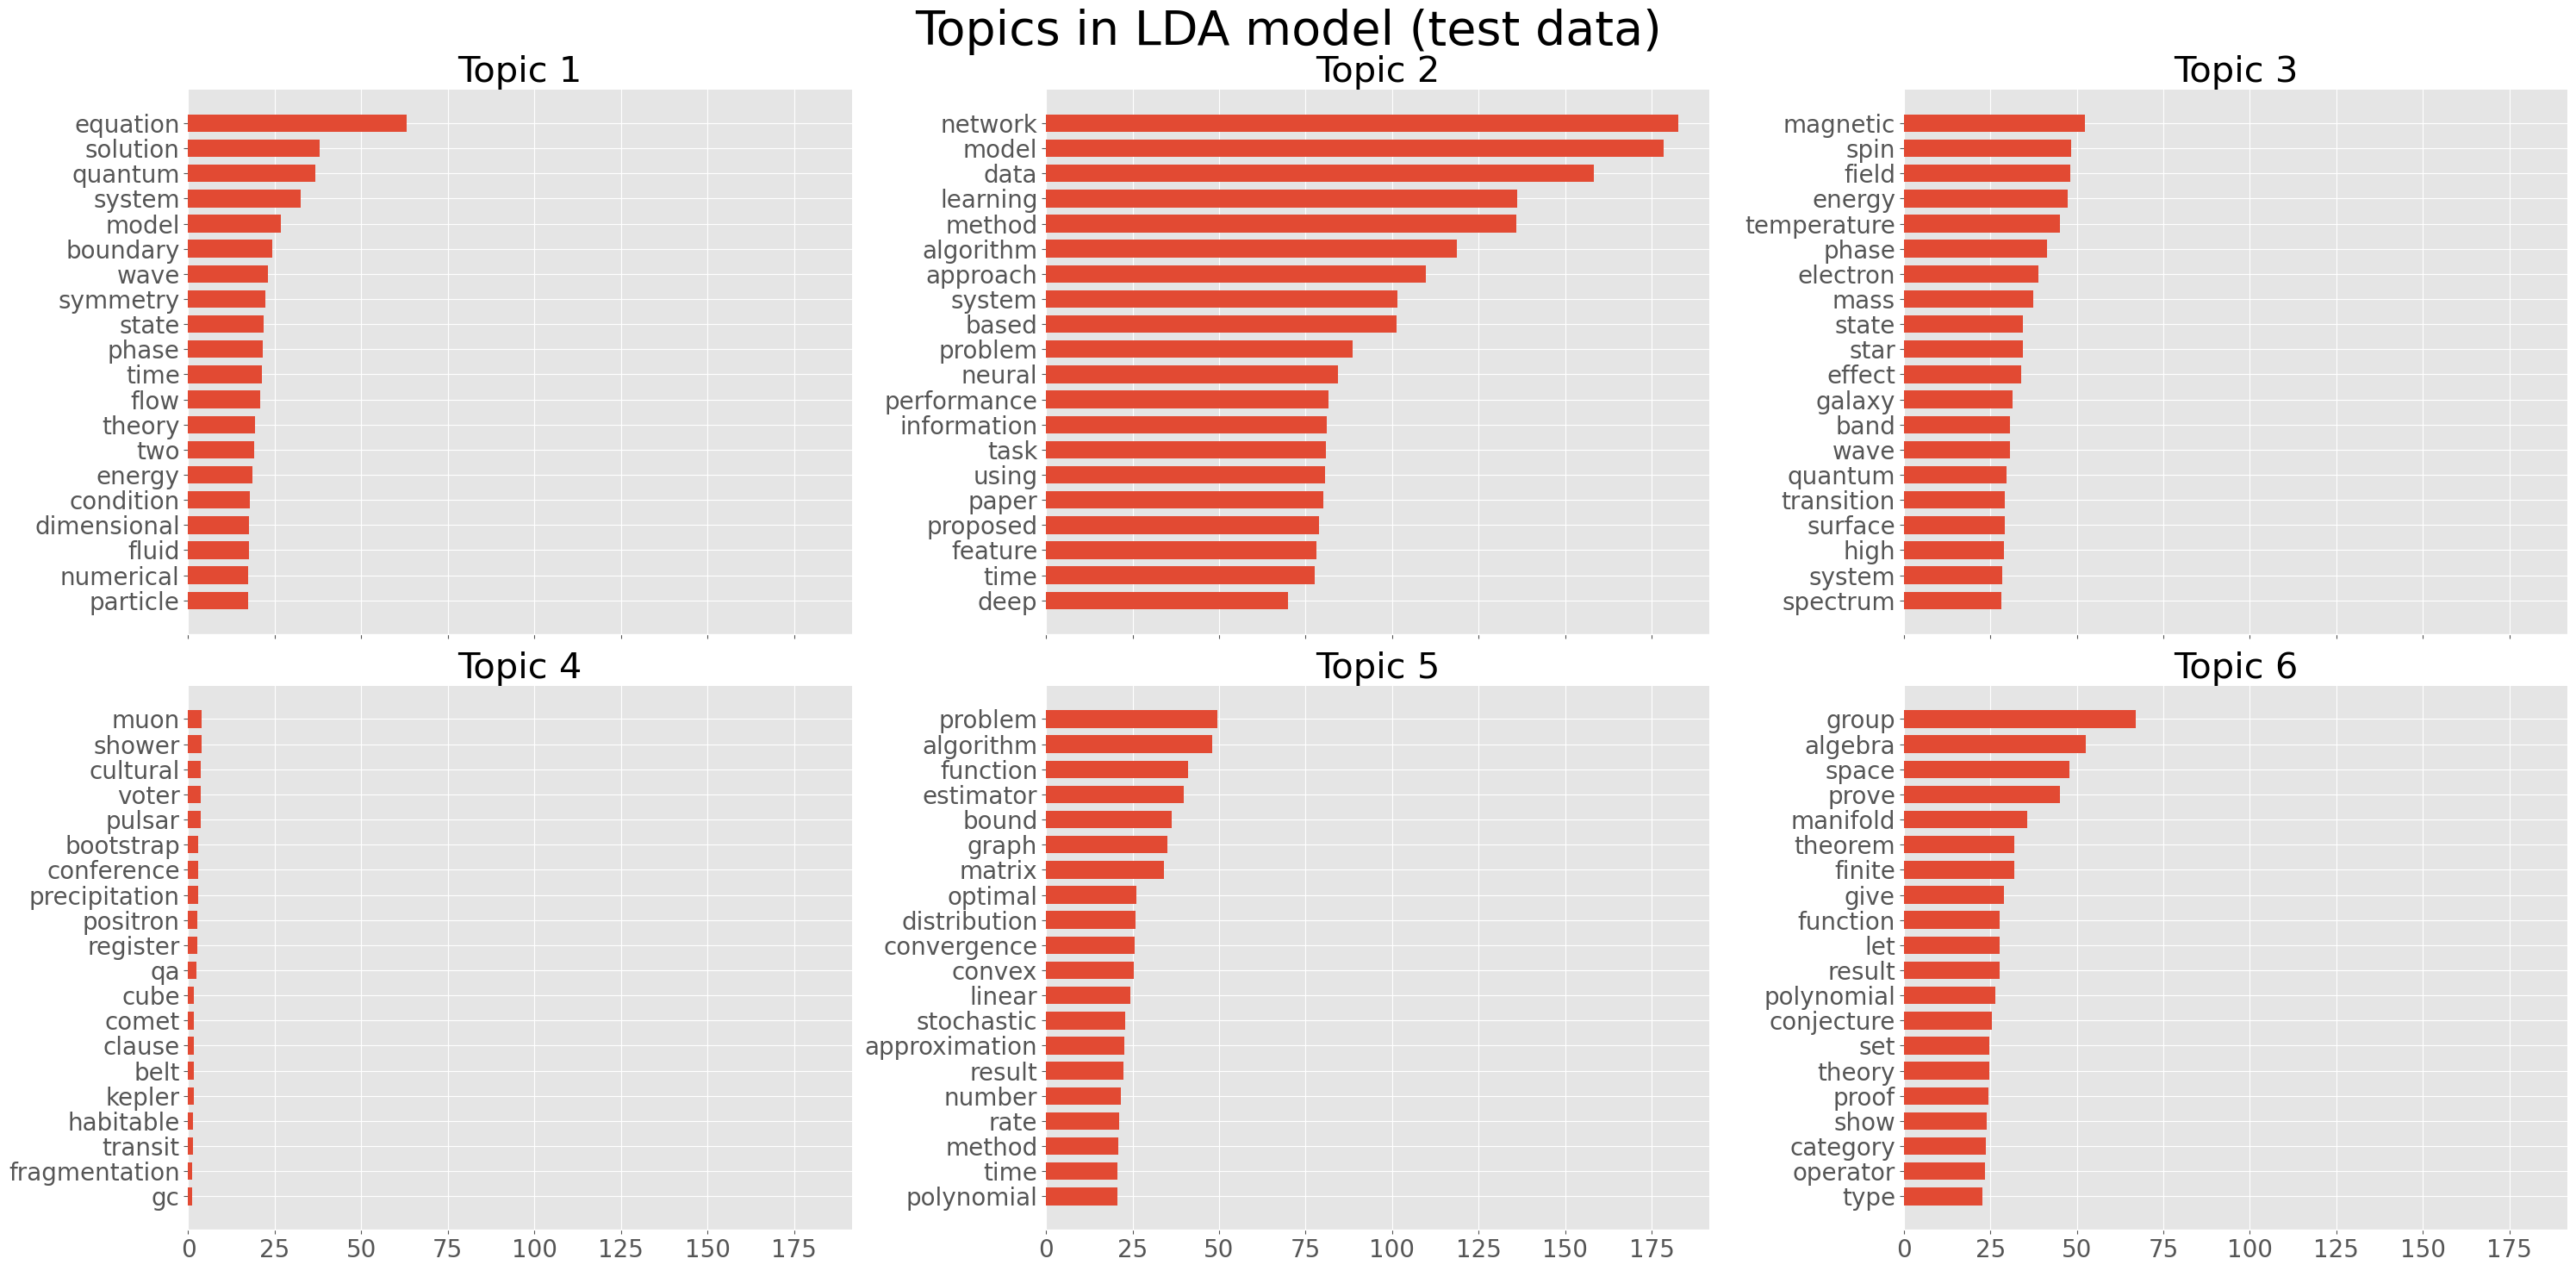

In [151]:
plot_top_words(LDA, tfidf_features, top_n_words, 'Topics in LDA model (test data)')